# How to view and update past graph state

Once you start [checkpointing](../persistence.ipynb) your graphs, you can easily **get** or **update** the state of the agent at any point in time. This permits a few things:

1. You can surface a state during an interrupt to a user to let them accept an action.
2. You can **rewind** the graph to reproduce or avoid issues.
3. You can **modify** the state to embed your agent into a larger system, or to let the user better control its actions.

The key methods used for this functionality are:

- [get_state](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.get_state): fetch the values from the target config
- [update_state](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.update_state): apply the given values to the target state

**Note:** this requires passing in a checkpointer.

Below is a quick example.

## Setup

First we need to install the packages required

In [24]:
# %%capture --no-stderr
# %pip install --quiet -U langgraph langchain_anthropic

Next, we need to set API keys for Anthropic (the LLM we will use)

In [1]:
import os
import logging
from dotenv import load_dotenv
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [2]:
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

load_dotenv()

True

## Build the agent

We can now build the agent. We will build a relatively simple ReAct-style agent that does tool calling. We will use Anthropic's models and a fake tool (just for demo purposes).

In [3]:
# Set up the tool
@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]


tools = [search]
tool_node = ToolNode(tools)

# Set up the model

model = ChatOpenAI(model="gpt-4o")
model = model.bind_tools(tools)


# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Set up memory
memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable

# We add in `interrupt_before=["action"]`
# This will add a breakpoint before the `action` node is called
app = workflow.compile(checkpointer=memory)

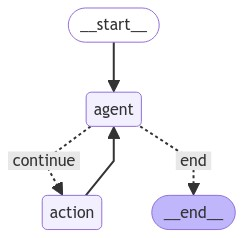

In [4]:
display(Image(app.get_graph().draw_mermaid_png()))

## Interacting with the Agent

We can now interact with the agent. Let's ask it for the weather in SF.


In [5]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Use the search tool to look up the weather in SF")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Use the search tool to look up the weather in SF


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  search (call_ZJgYA7bwhuIXcS5IW80DzLjK)
 Call ID: call_ZJgYA7bwhuIXcS5IW80DzLjK
  Args:
    query: current weather in San Francisco
================================= Tool Message =================================
Name: search

["It's sunny in San Francisco, but you better look out if you're a Gemini \ud83d\ude08."]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

The current weather in San Francisco is sunny. ☀️


## Checking history

Let's browse the history of this thread, from start to finish.

In [6]:
all_states = []
for state in app.get_state_history(config):
    print(state.next, state.values)
    all_states.append(state)
    print("--")
print(f"number of states: {len(all_states)}")

('__start__',) {'messages': []}
--
('agent',) {'messages': [HumanMessage(content='Use the search tool to look up the weather in SF', id='6d6d486b-f8b6-4ee4-a51d-3264df7345c7')]}
--
('action',) {'messages': [HumanMessage(content='Use the search tool to look up the weather in SF', id='6d6d486b-f8b6-4ee4-a51d-3264df7345c7'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZJgYA7bwhuIXcS5IW80DzLjK', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 53, 'total_tokens': 70}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_dd932ca5d1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4c2b0b32-2c5b-46b9-bc63-f8b5fbcd8405-0', tool_calls=[{'name': 'search', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_ZJgYA7bwhuIXcS5IW80DzLjK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 53, 'outp

## Replay a state

We can go back to any of these states and restart the agent from there! Let's go back to right before the tool call gets executed.

In [7]:
to_replay = all_states[2]

In [8]:
to_replay.values

{'messages': [HumanMessage(content='Use the search tool to look up the weather in SF', id='6d6d486b-f8b6-4ee4-a51d-3264df7345c7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZJgYA7bwhuIXcS5IW80DzLjK', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 53, 'total_tokens': 70}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_dd932ca5d1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4c2b0b32-2c5b-46b9-bc63-f8b5fbcd8405-0', tool_calls=[{'name': 'search', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_ZJgYA7bwhuIXcS5IW80DzLjK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 53, 'output_tokens': 17, 'total_tokens': 70})]}

In [9]:
to_replay.next

('action',)

To replay from this place we just need to pass its config back to the agent. Notice that it just resumes from right where it left all - making a tool call.

In [10]:
for event in app.stream(None, to_replay.config):
    for v in event.values():
        print(v)

{'messages': [ToolMessage(content='["It\'s sunny in San Francisco, but you better look out if you\'re a Gemini \\ud83d\\ude08."]', name='search', tool_call_id='call_ZJgYA7bwhuIXcS5IW80DzLjK')]}


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [AIMessage(content='The current weather in San Francisco is sunny. Enjoy the sunshine! ☀️', response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 102, 'total_tokens': 119}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_298125635f', 'finish_reason': 'stop', 'logprobs': None}, id='run-42fcd4ac-185d-4c69-af44-ebe75d5324f1-0', usage_metadata={'input_tokens': 102, 'output_tokens': 17, 'total_tokens': 119})]}


## Branch off a past state

Using LangGraph's checkpointing, you can do more than just replay past states. You can branch off previous locations to let the agent explore alternate trajectories or to let a user "version control" changes in a workflow.

Let's show how to do this to edit the state at a particular point in time. Let's update the state to change the input to the tool

In [15]:
# Let's now get the last message in the state
# This is the one with the tool calls that we want to update
last_message = to_replay.values["messages"][-1]

# Let's now update the args for that tool call
last_message.tool_calls[0]["args"] = {"query": "current weather in SF"}

branch_config = app.update_state(
    to_replay.config,
    {"messages": [last_message]},
)

We can then invoke with this new `branch_config` to resume running from here with changed state. We can see from the log that the tool was called with different input.

In [16]:
for event in app.stream(None, branch_config):
    for v in event.values():
        print(v)

{'messages': [ToolMessage(content='["It\'s sunny in San Francisco, but you better look out if you\'re a Gemini \\ud83d\\ude08."]', name='search', tool_call_id='call_ZJgYA7bwhuIXcS5IW80DzLjK')]}


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [AIMessage(content='The current weather in San Francisco is sunny. 🌞', response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 101, 'total_tokens': 113}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_d33f7b429e', 'finish_reason': 'stop', 'logprobs': None}, id='run-db467220-5c2c-4e17-8694-a54a102fc0f2-0', usage_metadata={'input_tokens': 101, 'output_tokens': 12, 'total_tokens': 113})]}


Alternatively, we could update the state to not even call a tool!

In [17]:
from langchain_core.messages import AIMessage

# Let's now get the last message in the state
# This is the one with the tool calls that we want to update
last_message = to_replay.values["messages"][-1]

# Let's now get the ID for the last message, and create a new message with that ID.
new_message = AIMessage(content="its warm!", id=last_message.id)

branch_config = app.update_state(
    to_replay.config,
    {"messages": [new_message]},
)

In [18]:
branch_state = app.get_state(branch_config)

In [19]:
branch_state.values

{'messages': [HumanMessage(content='Use the search tool to look up the weather in SF', id='6d6d486b-f8b6-4ee4-a51d-3264df7345c7'),
  AIMessage(content='its warm!', id='run-4c2b0b32-2c5b-46b9-bc63-f8b5fbcd8405-0')]}

In [20]:
branch_state.next

()

You can see the snapshot was updated and now correctly reflects that there is no next step.